In [152]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [153]:
os.listdir("WIT-UAV-Dataset")

['2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test',
 '2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect',
 '2022-05-11_FIRE-SGL-111-Confluence_M600-Data-Collect']

- seek cameras
- FLIR cameras


per folder: 
- how many total boxes per class?
- what percentage of detections to no detections?
- visualization of detection number over time?
- size statistics of boxes?
- height of UAS?

how to ensure similar distributions of fire vs no fire?

```
WIT-UAV-Dataset
├── 2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect
│   ├── 2021-11-07_19-19-31_dji_sdk_and_thermal.repaired
│   ├── 2021-11-07_19-19-36_dji_sdk_and_thermal.repaired
│   ├── 2021-11-07_19-19-54_dji_sdk_and_thermal
│   └── 2021-11-07_19-20-26_dji_sdk_and_thermal.repaired
├── 2022-05-11_FIRE-SGL-111-Confluence_M600-Data-Collect
│   ├── seek_displayImage
│   │   ├── 2022-04-27_00-18-06
│   │   ├── 2022-04-27_00-18-47
│   │   └── 2022-04-27_00-24-53
│   └── thermal_1_image_rect
│       ├── 2022-04-27_00-18-06
│       ├── 2022-04-27_00-18-47
│       └── 2022-04-27_00-24-53
└── 2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test
    ├── 2022-11-08_13-15-55_dji_sdk_and_thermal
    ├── 2022-11-08_14-13-12_dji_sdk_and_thermal
    └── 2022-11-08_14-40-21_dji_sdk_and_thermal.kinda-repaired-images-only_labeled
```

In [154]:
list_of_runs = []
for dirpath, dirnames, filenames in os.walk("WIT-UAV-Dataset"):
    if not dirnames:
        list_of_runs.append(dirpath)
        print(dirpath, "has 0 subdirectories and", len(filenames), "files")

WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test/2022-11-08_13-15-55_dji_sdk_and_thermal has 0 subdirectories and 250 files
WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test/2022-11-08_14-13-12_dji_sdk_and_thermal has 0 subdirectories and 193 files
WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test/2022-11-08_14-40-21_dji_sdk_and_thermal.kinda-repaired-images-only_labeled has 0 subdirectories and 660 files
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect/2021-11-07_19-19-54_dji_sdk_and_thermal has 0 subdirectories and 71 files
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect/2021-11-07_19-19-31_dji_sdk_and_thermal.repaired has 0 subdirectories and 417 files
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect/2021-11-07_19-20-26_dji_sdk_and_thermal.repaired has 0 subdirectories and 207 files
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect/2021-11-

In [155]:
list_of_runs

['WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test/2022-11-08_13-15-55_dji_sdk_and_thermal',
 'WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test/2022-11-08_14-13-12_dji_sdk_and_thermal',
 'WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test/2022-11-08_14-40-21_dji_sdk_and_thermal.kinda-repaired-images-only_labeled',
 'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect/2021-11-07_19-19-54_dji_sdk_and_thermal',
 'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect/2021-11-07_19-19-31_dji_sdk_and_thermal.repaired',
 'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect/2021-11-07_19-20-26_dji_sdk_and_thermal.repaired',
 'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect/2021-11-07_19-19-36_dji_sdk_and_thermal.repaired',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600-Data-Collect/seek_displayImage/2022-04-27_00-18-06',
 'WIT-UAV-Dataset/2022-05-11_

In [156]:
run = list_of_runs[1]

In [157]:
run

'WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test/2022-11-08_14-13-12_dji_sdk_and_thermal'

In [158]:
def count_detections_per_class(path):
    num_v = 0
    num_h = 0
    with open(path, "r") as f:
        lines = f.readlines()
        # if len(lines) == 0:
        #     print(lines)
        #     raise ValueError(f"File {path} is empty")
        for line in lines:
            if "v" in line or "c" in line:
                num_v += 1
            elif "h" in line:
                num_h += 1
            else:
                print(lines)
                raise ValueError(f"File {path} has no class")
    return num_v, num_h

In [159]:
def count_run_stats(run):
    num_total = 0
    num_labeled = 0
    total_num_v = 0
    total_num_h = 0
    width, height = 0, 0
    for f in os.listdir(run):
        if "label" in f: # is label file
            num_v, num_h = count_detections_per_class(run + "/" + f)
            total_num_v += num_v
            total_num_h += num_h

            if num_v > 0 or num_h > 0:
                num_labeled += 1
        else: # is image file
            if width == 0: # if resolution is not set, then set it
                # find resolution from image file
                img = cv2.imread(run + "/" + f)
                width, height, _ = img.shape
            num_total += 1
    
    # print(f"resolution={width}, {height}")
    # print(f"{num_total=}, {num_labeled=}, {total_num_v=}, {total_num_h=}")
    # print(f"percentage labeled={num_labeled/num_total}")
    return num_total, num_labeled, total_num_v, total_num_h, width, height

In [160]:
# pandas dataframe to store information about each run
df = pd.DataFrame(columns=["folder", "num_total", "num_labeled", "total_num_v", "total_num_h", "resolution"])

for run in list_of_runs:
    num_total, num_labeled, total_num_v, total_num_h, width, height = count_run_stats(run)
    # folder name is the run name minus the path
    folder = run.split("/")[-1]
    df = pd.concat([df, pd.DataFrame({"folder": folder, "num_total": num_total, "num_labeled": num_labeled, "total_num_v": total_num_v, "total_num_h": total_num_h, "resolution": f"{width}x{height}"}, index=[0])], ignore_index=True)

df.head()

,folder,num_total,num_labeled,total_num_v,total_num_h,resolution
0,2022-11-08_13-15-55_dji_sdk_and_thermal,130,24,3,76,240x320
1,2022-11-08_14-13-12_dji_sdk_and_thermal,112,28,64,160,240x320
2,2022-11-08_14-40-21_dji_sdk_and_thermal.kinda-...,330,53,73,11,240x320
3,2021-11-07_19-19-54_dji_sdk_and_thermal,49,22,0,33,512x640
4,2021-11-07_19-19-31_dji_sdk_and_thermal.repaired,368,47,36,176,512x640


Total percent labelled: 0.29645063945969247 %


,folder,num_total,num_labeled,total_num_v,total_num_h,resolution,percentage_labeled
0,2022-11-08_13-15-55_dji_sdk_and_thermal,130,24,3,76,240x320,18.461538
1,2022-11-08_14-13-12_dji_sdk_and_thermal,112,28,64,160,240x320,25.0
2,2022-11-08_14-40-21_dji_sdk_and_thermal.kinda-...,330,53,73,11,240x320,16.060606
3,2021-11-07_19-19-54_dji_sdk_and_thermal,49,22,0,33,512x640,44.897959
4,2021-11-07_19-19-31_dji_sdk_and_thermal.repaired,368,47,36,176,512x640,12.771739


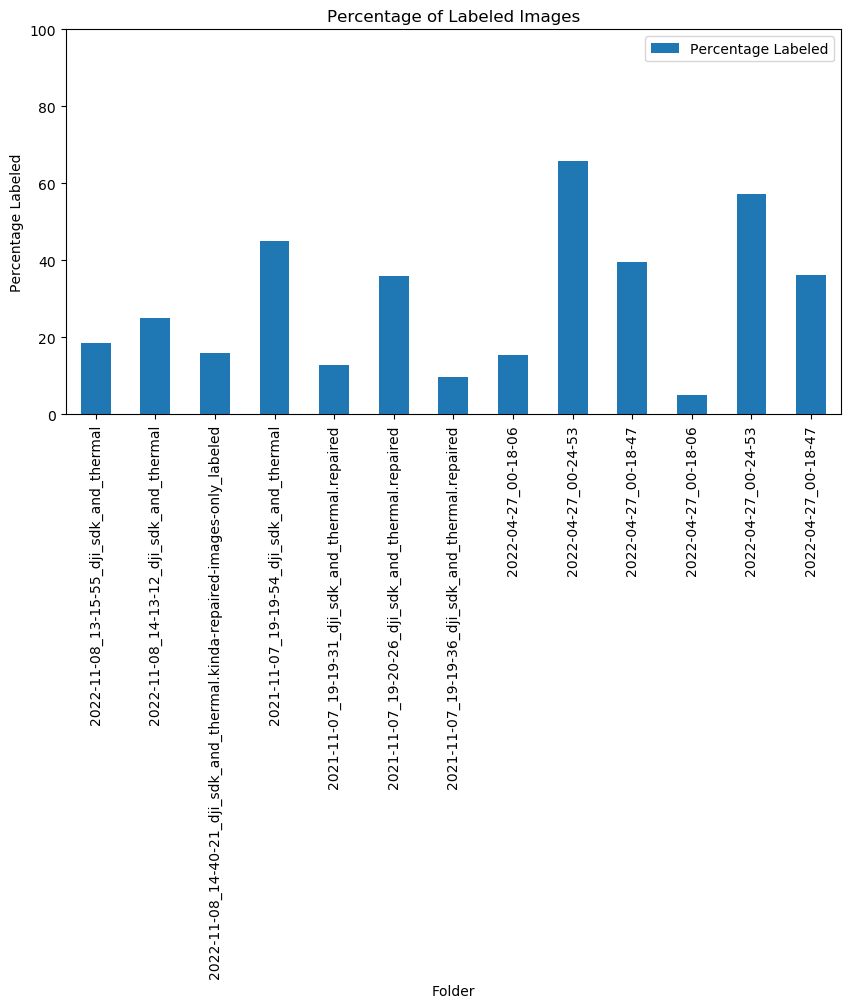

In [161]:
# find percentage of labeled images
df["percentage_labeled"] = df["num_labeled"] / df["num_total"] * 100
# find total percentage of labeled images
total_labeled = df["num_labeled"].sum() / df["num_total"].sum()
print(f"Total percent labelled: {total_labeled} %")
# plot percentage of labeled images vs folder. y scale is 0 to 100
df.plot(x="folder", y="percentage_labeled", kind="bar", figsize=(10, 5), ylim=(0, 100), title="Percentage of Labeled Images", ylabel="Percentage Labeled", xlabel="Folder")
plt.legend(["Percentage Labeled"])
df.head()

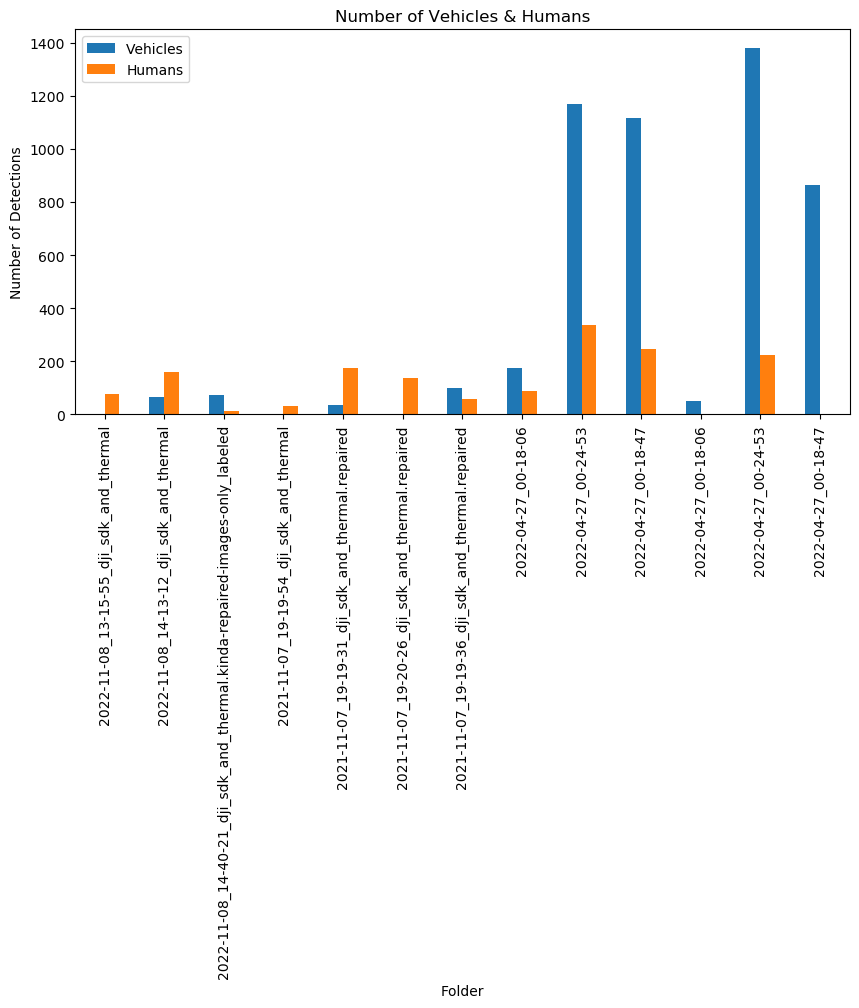

In [162]:
# plot number of vehicles and humans vs folder
# legend is number of vehicles and humans
df.plot(x="folder", y=["total_num_v", "total_num_h"], kind="bar", figsize=(10, 5), title="Number of Vehicles & Humans" , ylabel="Number of Detections", xlabel="Folder", legend=True)
plt.legend(["Vehicles", "Humans"])


Total number of 240x320 images: 3510
Total number of 512x640 images: 3449


Text(0, 0.5, 'Number of Images')

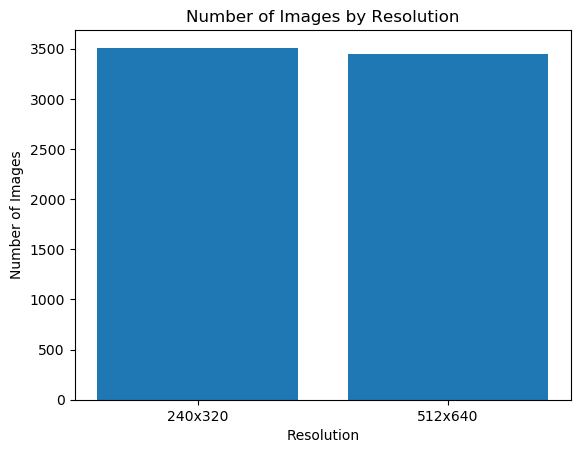

In [163]:
# find total number of 240x320 images
total_240x320 = df[df["resolution"] == "240x320"]["num_total"].sum()

# find total number of 512x640 images
total_512x640 = df[df["resolution"] == "512x640"]["num_total"].sum()

print(f"Total number of 240x320 images: {total_240x320}")
print(f"Total number of 512x640 images: {total_512x640}")

# plot number of 240x320 and 512x640 images calculated above with x,y labels and title
plt.bar(["240x320", "512x640"], [total_240x320, total_512x640])
plt.title("Number of Images by Resolution")
plt.xlabel("Resolution")
plt.ylabel("Number of Images")
